# Instruções para reproduzir os resultados do modelo final

In [ ]:
# instalar todas as bibliotecas utilizadas
!pip install -r requirements.txt

## 1. Pré-processar o conjunto de dados

Execute as celulas abaixo para realizar o pré-processar os dados presentes no arquivo 'ep2-pln-train.xlsx' dentro da pasta 'data'. Você deve obter como resultado o arquivo 'enc_tok_nopunct_lemm.csv' que está armazenado em 'data'

In [86]:
from preprocess import preprocess
import pandas as pd
import numpy as np
from scipy.sparse import save_npz, load_npz

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier

from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import accuracy_score, confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder

from sklearn.feature_extraction.text import TfidfVectorizer

import pickle
import blosc

import shap

import warnings

warnings.filterwarnings("ignore")

seed = np.random.seed(777)

In [4]:
df = pd.read_excel('data/ep2-pln-train.xlsx')

preprocess.encode_class(df, 'age')

preprocess.tokenize(df, 'req_text', True, True)

preprocess.lemmatize(df, 'word_tokens', True)

df.to_csv('data/enc_tok_nopunct_lemm.csv', index=False)

## 2. Vetorizar conjunto de dados limpo

Execute o notebook jupyter 'vectorizer.ipynb' que está no diretório 'processing'. Você deve obter como resultado os arquivos {'X_train_Tfidf.npz', 'X_test_Tfidf.npz', 'y_train.npy', 'y_test.npy'} armazenado em 'vects'

In [5]:
df = pd.read_csv('data/enc_tok_nopunct_lemm.csv')

X_labels = [i for i in df.columns if (i != 'age' and i != 'age_encoded')]
X = df['lemma']
y = df['age_encoded']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.8, stratify=df['age_encoded'], random_state=seed)

tfidf_vect = TfidfVectorizer(max_features=5000)
tfidf_vect.fit(X)

X_train_tfidf = tfidf_vect.transform(X_train)
X_test_tfidf = tfidf_vect.transform(X_test)

save_npz('vectors/tfidf_lemma/X_train_tfidf.npz', X_train_tfidf)
save_npz('vectors/tfidf_lemma/X_test_tfidf.npz', X_test_tfidf)

np.save('vectors/tfidf_lemma/y_train.npy', y_train)
np.save('vectors/tfidf_lemma/y_test.npy', y_test)

## 3. Escolha dos hiperparâmetros dos modelos selecionados

### 3.0 Carregar vetores de treino e teste

In [15]:
X_train = load_npz('vectors/tfidf_lemma/X_train_tfidf.npz')
X_test = load_npz('vectors/tfidf_lemma/X_test_tfidf.npz')

y_train = np.load('vectors/tfidf_lemma/y_train.npy', allow_pickle=True)
y_test = np.load('vectors/tfidf_lemma/y_test.npy', allow_pickle=True)

### 3.1 Melhores hiperparâmetros

Para encontrar os melhores hiperparâmetros utilizamos a biblioteca 'optuna', mais detatlhes de como essa busca foi feita estão no arquivo 'NB_SVM_RF_tfidf.ipynb' dentro do diretório 'classic_models'. Aqui apenas treinaremos os modelos usando os hiperparâmetros encontrados.

In [16]:
class_weights = dict(zip(range(len(np.unique(y_train))), 1 / np.bincount(y_train)))
labels = ['0','1','2','3']

SVM_params = {
    'class_weight': 'balanced', 
    'probability': True,
}

RF_params = {
    'n_estimators': 167,
    'max_depth': 176,
    'class_weight': class_weights,
}

In [17]:
SVM = SVC(**SVM_params)
RF = RandomForestClassifier(**RF_params)

In [18]:
SVM.fit(X_train, y_train)
RF.fit(X_train, y_train)

RandomForestClassifier(class_weight={0: 0.0010416666666666667, 1: 0.000625,
                                     2: 0.0004166666666666667, 3: 0.000625},
                       max_depth=176, n_estimators=167)

In [19]:
SVM_y_pred = SVM.predict(X_test)
RF_y_pred = RF.predict(X_test)

In [20]:
cm_SVM = confusion_matrix(y_test, SVM_y_pred)
cm_SVM = cm_SVM.astype('float') / cm_SVM.sum(axis=1)[:, np.newaxis]

cm_RF = confusion_matrix(y_test, RF_y_pred)
cm_RF = cm_RF.astype('float') / cm_RF.sum(axis=1)[:, np.newaxis]

### 3.2 visualização dos resultados em cada classe
optamos por gerar matrizes de confusão para verificar como os modelos estavam obtendo a sua acurácia média, dado que o conujunto de dados era desbalanceado.

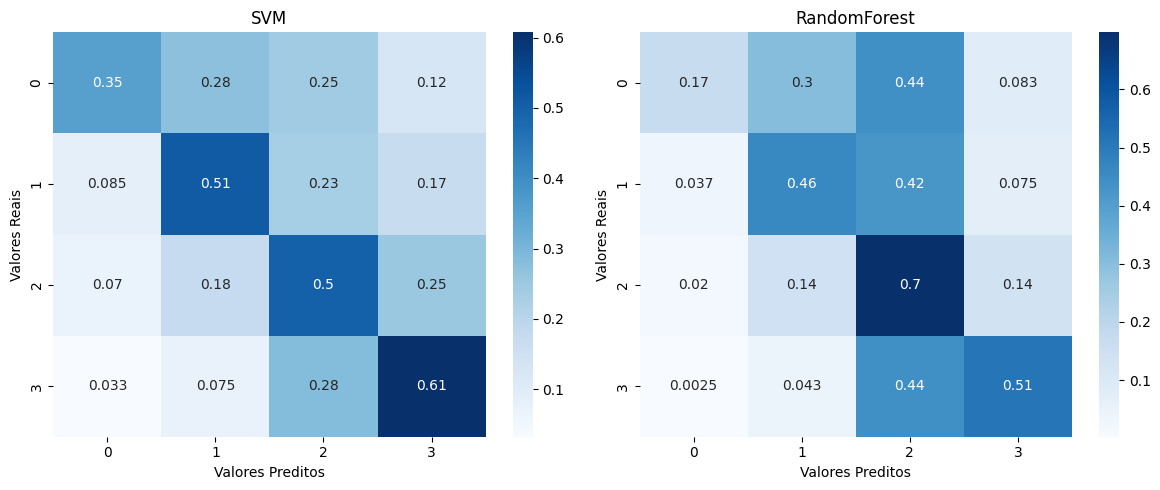

In [21]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

for i, (cm, model_name) in enumerate(zip([cm_SVM, cm_RF], ['SVM', 'RandomForest'])):
    sns.heatmap(cm, annot=True, cmap="Blues", xticklabels=labels, yticklabels=labels, ax=axes[i])
    axes[i].set_title(f'{model_name}')
    axes[i].set_xlabel('Valores Preditos')
    axes[i].set_ylabel('Valores Reais')

plt.tight_layout()
plt.show()

In [22]:
with open('models_dump/SVM_CV50_T50.pkl', 'wb') as file:
    pickle.dump(SVM, file)

with open('models_dump/RF_CV51_T51.pkl', 'wb') as file:
    pickle.dump(RF, file)

## 4. Gerando ensemble dos modelos selecionados

In [23]:
weights = {'RF': [1,1,1,3], 'SVM': [3,2,2,1]}

In [24]:
def get_weighted_probabilities(models, X, weights):
    probabilities = [model.predict_proba(X) * weight for (model, weight) in zip(models, weights.values())]
    return np.sum(probabilities, axis=0)

In [25]:
ensemble_proba = get_weighted_probabilities([SVM, RF], X_test, weights)

ensemble_model = VotingClassifier(estimators=[
    ('RF', RF),
    ('SVM', SVM)
], voting='soft', weights=weights)

In [26]:
ensemble_model.fit(X_train, y_train)

VotingClassifier(estimators=[('RF',
                              RandomForestClassifier(class_weight={0: 0.0010416666666666667,
                                                                   1: 0.000625,
                                                                   2: 0.0004166666666666667,
                                                                   3: 0.000625},
                                                     max_depth=176,
                                                     n_estimators=167)),
                             ('SVM',
                              SVC(class_weight='balanced', probability=True))],
                 voting='soft',
                 weights={'RF': [1, 1, 1, 3], 'SVM': [3, 2, 2, 1]})

### 4.1 Acurácia do ensemble no conjunto de teste

In [89]:
ensemble_predictions = np.argmax(ensemble_proba, axis=1)
print(f'Acurácia do Ensemble: {accuracy_score(y_test, ensemble_predictions)}')

Acurácia do Ensemble: 0.5231707317073171


### 4.2 Acurácia média do ensemble em um cross validation com 10 folds
Obs.: Criamos uma função para esse ensemble, pois a função 'cross_validation_score' do sklearn não suporta os modelos que usamos. Entretanto, vale ressaltar que utilizamos a função 'Kfold' do 'sklearn' para manter a consistência.

In [19]:
def cv_scores(X, y):
    kf = KFold(n_splits=10, shuffle=True, random_state=42)

    # Inicializando listas para armazenar pontuações
    cross_val_scores = []

    # Realizando a validação cruzada manualmente
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Treinando os modelos com pesos
        SVM.fit(X_train, y_train)
        RF.fit(X_train, y_train)

        # Calculando probabilidades ponderadas usando a função personalizada
        weighted_probabilities = get_weighted_probabilities([SVM, RF], X_test, weights)

        # Convertendo probabilidades para previsões
        ensemble_predictions = np.argmax(weighted_probabilities, axis=1)

        # Calculando a acurácia e armazenando
        accuracy = np.sum(ensemble_predictions == y_test) / len(y_test)
        cross_val_scores.append(accuracy)
    return cross_val_scores

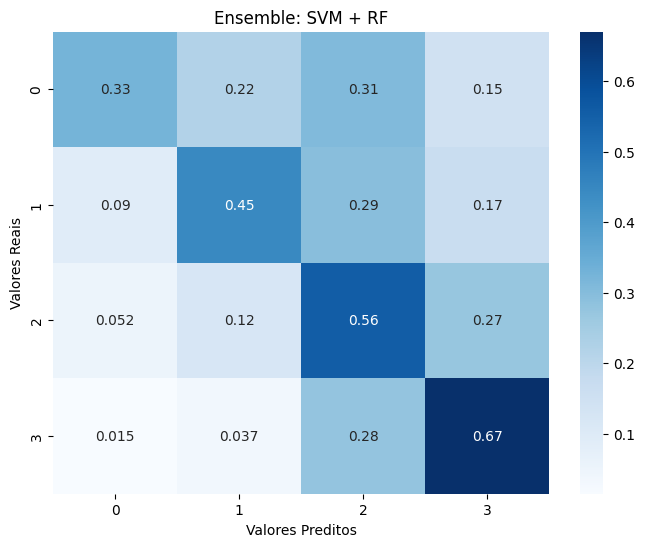

In [28]:
cm = confusion_matrix(y_test, ensemble_predictions)

cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.title('Ensemble: SVM + RF')
plt.xlabel('Valores Preditos')
plt.ylabel('Valores Reais')
plt.show()

In [21]:
cross_val_scores = cv_scores(X_train, y_train)

# Exibindo as pontuações para cada fold
print("Pontuações da validação cruzada:", cross_val_scores)

# Exibindo a média das pontuações
print("Média das pontuações da validação cruzada:", np.mean(cross_val_scores))

Pontuações da validação cruzada: [0.5213414634146342, 0.5015243902439024, 0.5320121951219512, 0.5228658536585366, 0.5213414634146342, 0.5060975609756098, 0.48628048780487804, 0.5228658536585366, 0.4817073170731707, 0.5320121951219512]
Média das pontuações da validação cruzada: 0.5128048780487804


In [87]:
pickle_model = pickle.dumps(ensemble_model)

compressed_pickle_model = blosc.compress(pickle_model)

with open('./models_dump/SVM+RF_CV51_T52.dat', 'wb') as file:
    file.write(compressed_pickle_model)

In [88]:
with open("./models_dump/SVM+RF_CV51_T52.dat", "rb") as file:
    compressed_pickle_model = file.read()

depressed_pickle_model = blosc.decompress(compressed_pickle_model)
ensemble_model = pickle.loads(depressed_pickle_model) 

# Classificando os casos de teste

In [67]:
ep2_teste = pd.read_excel('./data/ep2-pln-test.xlsx')
ep2_teste_original = ep2_teste.copy()
ep2_teste.head()

,req_text,age
0,"Prezados Senhores, Solicito cópia, completa, d...",NaN
1,BOM DIA. GOSTARIA DE SABER SE HÁ IMPEDIMENTO L...,NaN
2,"Bom dia. Para fins de pesquisa, estou em busca...",NaN
3,É OBRIGATÓRIO A EMISSÃO DO DOF PELO FORNECEDOR...,NaN
4,Bom dia. Sou advogado e meu cliente está receb...,NaN


In [68]:
preprocess.encode_class(ep2_teste, 'age')

preprocess.tokenize(ep2_teste, 'req_text', True, True)

preprocess.lemmatize(ep2_teste, 'word_tokens', True)
ep2_teste.head()

,req_text,age,age_encoded,word_tokens,lemma
0,prezados senhores solicito cópia completa do p...,NaN,0,"[prezados, senhores, solicito, cópia, completa...",prezar senhor solicito cópia completo de o pro...
1,bom dia gostaria de saber se há impedimento le...,NaN,0,"[bom, dia, gostaria, de, saber, se, há, impedi...",bom dia gostar de saber se haver impedimento l...
2,bom dia para fins de pesquisa estou em busca d...,NaN,0,"[bom, dia, para, fins, de, pesquisa, estou, em...",bom dia para fim de pesquisa estar em busca de...
3,é obrigatório a emissão do dof pelo fornecedor...,NaN,0,"[é, obrigatório, a, emissão, do, dof, pelo, fo...",ser obrigatório o emissão de o dof por o forne...
4,bom dia sou advogado e meu cliente está recebe...,NaN,0,"[bom, dia, sou, advogado, e, meu, cliente, est...",bom dia ser advogado e meu cliente estar receb...


In [69]:
df = pd.read_csv('data/enc_tok_nopunct_lemm.csv')
df.groupby('age').head()

,req_text,age,age_encoded,word_tokens,lemma
0,quantos empregados em cada um dos atuais níve...,a2,1,"['quantos', 'empregados', 'em', 'cada', 'um', ...",quanto empregado em cada um de o atual nível s...
1,solicito cópia das atas do conselho de admini...,a2,1,"['solicito', 'cópia', 'das', 'atas', 'do', 'co...",solicito cópia de o ata de o conselho de admin...
2,solicito informar a norma lei decreto portari...,a2,1,"['solicito', 'informar', 'a', 'norma', 'lei', ...",solicito informar o norma lei decreto portaria...
3,solicito por gentileza a informação sobre a q...,a2,1,"['solicito', 'por', 'gentileza', 'a', 'informa...",solicito por gentileza o informação sobre o qu...
4,solicito por gentileza a informação sobre a q...,a2,1,"['solicito', 'por', 'gentileza', 'a', 'informa...",solicito por gentileza o informação sobre o qu...
72, quantos cargos para engenheiro agrônomo exis...,a1,0,"['\x96', 'quantos', 'cargos', 'para', 'engenhe...",\x96 quanto cargo para engenheiro agrônomo exi...
74,gostaria de solicitar a lista dos servidores ...,a1,0,"['\x91gostaria', 'de', 'solicitar', 'a', 'list...",\x91gostaria de solicitar o lista de o servido...
75,01 quando o mec definirá o novo piso nacional ...,a3,2,"['01', 'quando', 'o', 'mec', 'definirá', 'o', ...",01 quando o mec definir o novo piso nacional d...
78,1 acesso ao inquérito já concluído de número ...,a1,0,"['1', 'acesso', 'ao', 'inquérito', 'já', 'conc...",1 acesso a o inquérito já concluir de número 6...
79,1 além do salário quais são os benefícios dos...,a3,2,"['1', 'além', 'do', 'salário', 'quais', 'são',...",1 além de o salário qual ser o benefício de o ...


In [70]:
X = df['lemma']
tfidf_vect = TfidfVectorizer(max_features=5000)
tfidf_vect.fit(X)

ep2_teste_tfidf = tfidf_vect.transform(ep2_teste['lemma'])

In [71]:
ensemble_proba_teste = get_weighted_probabilities([SVM, RF], ep2_teste_tfidf, weights)

ensemble_predictions_teste = np.argmax(ensemble_proba_teste, axis=1)

ensemble_predictions_teste_series = pd.Series(ensemble_predictions_teste)

In [72]:
ensemble_predictions_teste_series

0      3
1      3
2      2
3      3
4      2
      ..
395    3
396    2
397    2
398    2
399    1
Length: 400, dtype: int64

In [73]:
ep2_teste_original['age'] = ensemble_predictions_teste_series
ep2_teste_final = ep2_teste_original.copy()

In [74]:
mapeamento = {
    0: 'a1',
    1: 'a2',
    2: 'a3',
    3: 'a4'
}

In [75]:
ep2_teste_final.head()

,req_text,age
0,"Prezados Senhores, Solicito cópia, completa, d...",3
1,BOM DIA. GOSTARIA DE SABER SE HÁ IMPEDIMENTO L...,3
2,"Bom dia. Para fins de pesquisa, estou em busca...",2
3,É OBRIGATÓRIO A EMISSÃO DO DOF PELO FORNECEDOR...,3
4,Bom dia. Sou advogado e meu cliente está receb...,2


In [76]:
ep2_teste_final['age'] = ep2_teste_final['age'].map(mapeamento)

In [77]:
ep2_teste_final.head()

,req_text,age
0,"Prezados Senhores, Solicito cópia, completa, d...",a4
1,BOM DIA. GOSTARIA DE SABER SE HÁ IMPEDIMENTO L...,a4
2,"Bom dia. Para fins de pesquisa, estou em busca...",a3
3,É OBRIGATÓRIO A EMISSÃO DO DOF PELO FORNECEDOR...,a4
4,Bom dia. Sou advogado e meu cliente está receb...,a3


In [78]:
ep2_teste_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   req_text  400 non-null    object
 1   age       400 non-null    object
dtypes: object(2)
memory usage: 6.4+ KB


In [80]:
ep2_teste_final.to_excel('results/ep2-pln-test-resultados.xlsx')

(array([  4.,   0.,   0.,  40.,   0.,   0., 220.,   0.,   0., 136.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <BarContainer object of 10 artists>)

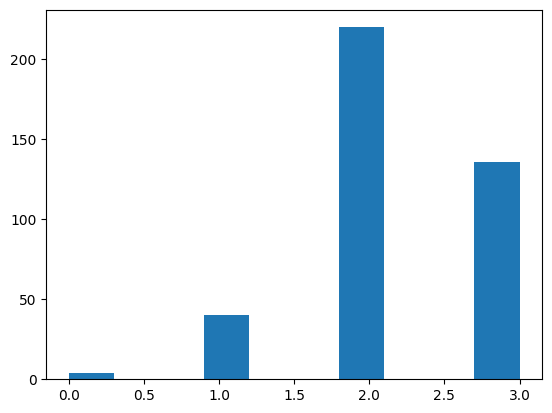

In [90]:
plt.hist(ensemble_predictions_teste)